In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt

import shannonUtils

sns.set_theme()

In [2]:
from shannonUtils import initModel, investmentModelCash

<AxesSubplot:title={'center':'Random walk, 50% chance to double (100% return), 50% chance to half (-50% return)'}, xlabel='time', ylabel='value'>

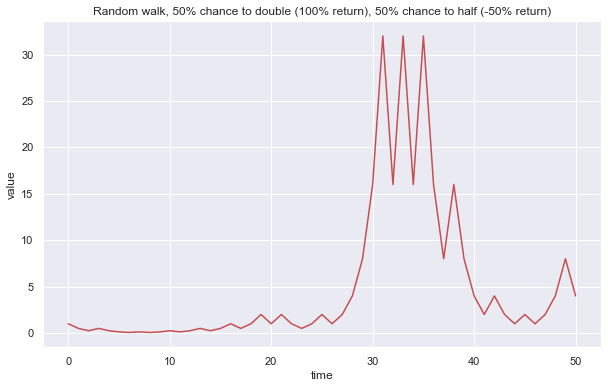

In [3]:
resArr = initModel(50,1,0.5)
pd.Series(resArr).plot(kind='line',figsize=(10,6),
                       title='Random walk, 50% chance to double (100% return), 50% chance to half (-50% return)',
                       xlabel='time',ylabel='value',color=['r'])

In [4]:
outDf = investmentModelCash(0.5,resArr)

<AxesSubplot:title={'center':'cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio'}, xlabel='time', ylabel='cumulative return'>

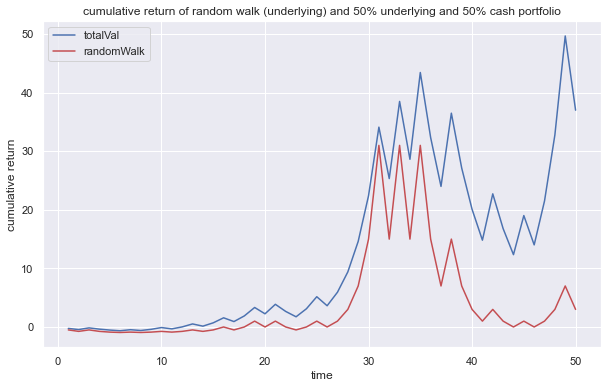

In [5]:
# plot results of portfolio and random walk
((outDf[['totalVal','randomWalk']].pct_change()+1).cumprod()-1).plot(kind='line',figsize=(10,6),
                                                                     title='cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio',
                                                                     xlabel='time',ylabel='cumulative return',color=['b','r'])